# Import

In [1]:
!pip3 install torchsummary

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils import data
from torchvision import transforms, utils
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy
from collections import defaultdict
import random
from tqdm import tqdm
import os
import re
import math

In [3]:
input_folder = "/kaggle/input/single-npy-extracted-from-brats2015/features_npy"
output_folder = "/kaggle/input/single-npy-extracted-from-brats2015/labels_npy"

In [4]:
def read_images(root_path):
    train_imgs = []
    test_imgs = []
    vali_imgs = []
    for root, dirs, files in os.walk(root_path):
#         print("path：", root)
#         print("directory：", dirs)
#         print("file：", files)
#         namel = str.split(files,"_")
        files.sort()
        for file_name in tqdm(files):
            namel = str.split(file_name,"_")
            if int(namel[0]) < 254: 
                train_imgs.append(root + "/" + file_name)
            elif int(namel[0]) < 264:
                vali_imgs.append(root + "/" + file_name)
            else:
                test_imgs.append(root + "/" + file_name)
    print("Read ",len(train_imgs), " files")
    print("Read ",len(vali_imgs), " files")
    print("Read ",len(test_imgs), " files")
    return train_imgs, vali_imgs, test_imgs

In [5]:
train_imgs, vali_imgs, test_imgs = read_images(input_folder)
train_masks, vali_masks, test_masks = read_images(output_folder)

100%|██████████| 24660/24660 [00:00<00:00, 698003.38it/s]


Read  22770  files
Read  900  files
Read  990  files


100%|██████████| 24660/24660 [00:00<00:00, 515495.21it/s]

Read  22770  files
Read  900  files
Read  990  files


In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

(4, 192, 192)


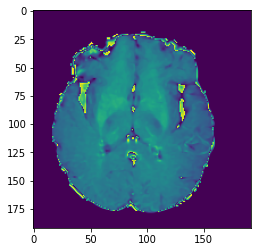

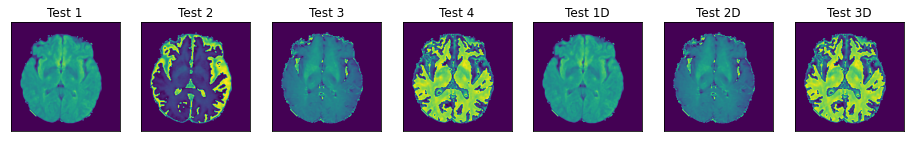

In [7]:
test_np = np.load(train_imgs[30]).astype('uint8')
test_np_de = np.delete(test_np, 1, 0)
print(test_np.shape)
test_np = np.moveaxis(test_np, 0, 2)
test_np_de = np.moveaxis(test_np_de, 0, 2)
test_img = Image.fromarray(test_np[:,:,2].squeeze())
# test_img.shape
plt.imshow(test_img)

visualize(
    test_1=test_np[..., 0].squeeze(),
    test_2=test_np[..., 1].squeeze(),
    test_3=test_np[..., 2].squeeze(),
    test_4=test_np[..., 3].squeeze(),
    
    test_1d=test_np_de[..., 0].squeeze(),
    test_2d=test_np_de[..., 1].squeeze(),
    test_3d=test_np_de[..., 2].squeeze(),
)

/kaggle/input/single-npy-extracted-from-brats2015/labels_npy/101_1_gt.npy
uint8
(192, 192, 1)
[0 2]


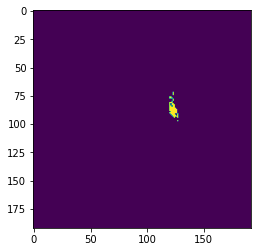

In [8]:
test_np = np.load(train_masks[30])
print(train_masks[100])
print(test_np.dtype)
test_np = np.moveaxis(test_np, 0, 2)
print(test_np.shape)
print(np.unique(test_np))
test_img = Image.fromarray(test_np.squeeze())
# # test_img.shape
plt.imshow(test_img)

# Dataset

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [10]:
a = np.array([1,0,0])
b = np.array([0,1,0])
np.add(a, b)

array([1, 1, 0])

In [11]:
class BraTs_Dataset(Dataset):
    CLASSES = ['else', 'necrosis', 'edema', 'non_enhancing_tumor', 'enhancing_tumor']
    def __init__(self, data_list, label_list, classes, transform=None):

        self.data_list = data_list
        self.label_list = label_list
        self.transform = transform
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
#         print("class_values", self.class_values)
        print('Read ' + str(len(self.data_list)) + ' images')
    
    def __getitem__(self, index):
        # read data
        # image
        image = np.load(self.data_list[index]).astype('uint8')
        image = np.delete(image, 1, 0)
        image = np.moveaxis(image, 0, 2)
#         image = image.resize(self.resize_size, resample=Image.LANCZOS)
#         print(image.shape)
        # mask
        mask = np.load(self.label_list[index])
#         mask = np.moveaxis(mask, 0, 2)
#         print(np.unique(mask))
        mask = mask.squeeze()
#         mask = cv2.resize(mask, self.resize_size, interpolation=cv2.INTER_NEAREST)

        # extract certain classes from mask (e.g. cars)
#         print(self.class_values)
        masks = [(mask == v) for v in self.class_values]
#         print(len(masks))
        mask = np.stack(masks, axis=-1).astype('float')
#         print('mask shape :{}'.format(mask.shape))
#         print(np.unique(mask))
        whole_tumor_mask = mask
        whole_tumor_mask[...,1] = np.add(whole_tumor_mask[...,1], whole_tumor_mask[...,2])
        whole_tumor_mask[...,1] = np.add(whole_tumor_mask[...,1], whole_tumor_mask[...,3])
        whole_tumor_mask[...,1] = np.add(whole_tumor_mask[...,1], whole_tumor_mask[...,4])
       
        whole_tumor_mask = whole_tumor_mask[...,:2]
        img_path = self.data_list[index]
        lable_path = self.label_list[index]
        
        if self.transform:
            image = self.transform(image)
            mask = np.moveaxis(mask, 2, 0)
            whole_tumor_mask = np.moveaxis(whole_tumor_mask, 2, 0)
            
#         return image, mask, img_path, lable_path
        return {'image': image, 'mask': mask, 'whole_tumor_mask': whole_tumor_mask, 
                'img_path':img_path, 'lable_path':lable_path}
    
    def __len__(self):
        return len(self.data_list)

In [12]:
# train_imgs, vali_imgs, test_imgs
# train_masks, vali_masks, test_masks
classes = ['else', 'necrosis', 'edema', 'non_enhancing_tumor', 'enhancing_tumor']
train_dataset = BraTs_Dataset(train_imgs, train_masks, classes=classes, transform=transform)
vali_dataset = BraTs_Dataset(vali_imgs, vali_masks, classes=classes, transform=transform)
test_dataset = BraTs_Dataset(test_imgs, test_masks, classes=classes, transform=transform)
test_dataset_vis = BraTs_Dataset(test_imgs, test_masks, classes=classes)

Read 22770 images
Read 900 images
Read 990 images
Read 990 images


In [13]:
def show_data(dataset, idx, vis=True):
    
    # dataset
    data = dataset[idx] # get some sample
    image = np.array(data['image'])  
    mask = np.array(data['mask'])
    whole_tumor_mask = np.array(data['whole_tumor_mask'])
    img_path = data['img_path']
    lable_path = data['lable_path']
    
    # original image
    org_img = np.load(img_path).astype('uint8')
    org_img_de = np.delete(org_img, 1, 0)
    print(org_img.shape)
    org_img = np.moveaxis(org_img, 0, 2)
    org_img_de = np.moveaxis(org_img_de, 0, 2)
    
    # original mask
    org_mask = np.load(lable_path)
#         print(test_np.dtype)
    org_mask = np.moveaxis(org_mask, 0, 2)
    
    
    visualize(
        org_img_flair=org_img[..., 0].squeeze(),
        org_img_t1=org_img[..., 1].squeeze(),
        org_img_t1c=org_img[..., 2].squeeze(),
        org_img_t2=org_img[..., 3].squeeze(),          
    )
        
    visualize(
        org_img_flair=org_img_de[..., 0].squeeze(),
        org_img_t1c=org_img_de[..., 1].squeeze(),
        org_img_t2=org_img_de[..., 2].squeeze(),
        org_mask = org_mask.squeeze(),
    )
    if vis:  
        visualize(
            image=image, 
            else_mask=mask[..., 0].squeeze(),
            necrosis_mask=mask[..., 1].squeeze(),
            edema_mask=mask[..., 2].squeeze(),
            non_enhancing_tumor_mask=mask[..., 3].squeeze(),
            enhancing_tumor_mask=mask[..., 4].squeeze(),
        )
        visualize(
            image=image, 
            else_mask=whole_tumor_mask[..., 0].squeeze(),
            whole_tumor_mask = whole_tumor_mask[..., 1].squeeze(),
        )
    print(img_path)
    print(lable_path)
    print('original image shape: {}'.format(org_img.shape))
    print('original image deleted 1d shape: {}'.format(org_img_de.shape))
    print('original mask shape: {}'.format(org_mask.shape))
    print('original mask unique values: {}'.format(np.unique(org_mask)))
    print('dataset image shape: {}'.format(image.shape))
    print('dataset mask shape: {}'.format(mask.shape))
    print('dataset mask unique values: {}'.format(np.unique(mask)))
    print('dataset else mask unique values: {}'.format(np.unique(mask[..., 0])))
    print('dataset necrosis mask unique values: {}'.format(np.unique(mask[..., 1])))
    print('dataset edema mask unique values: {}'.format(np.unique(mask[..., 2])))
    print('dataset non enhancing tumor mask unique values: {}'.format(np.unique(mask[..., 3])))
    print('dataset enhancing tumor mask unique values: {}'.format(np.unique(mask[..., 4])))
    print('dataset whole tumor mask shape: {}'.format(whole_tumor_mask.shape))
    print('dataset whole tumor mask unique values: {}'.format(np.unique(whole_tumor_mask)))

(4, 192, 192)


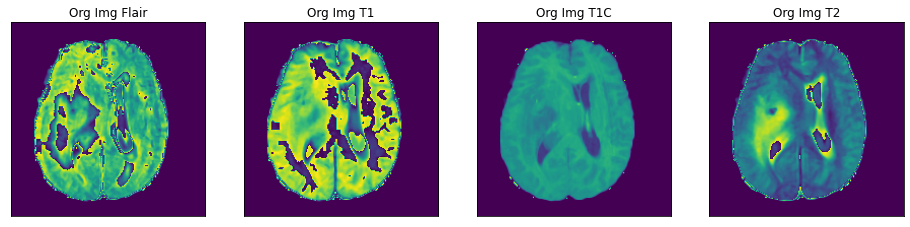

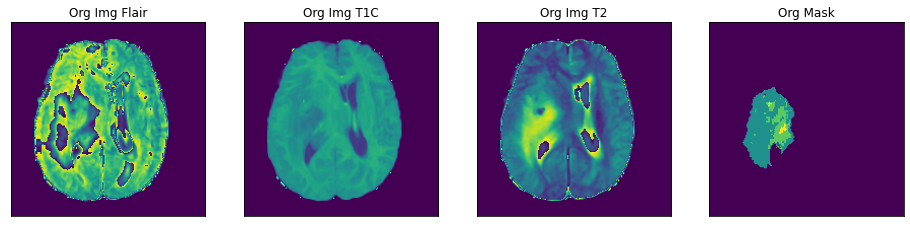

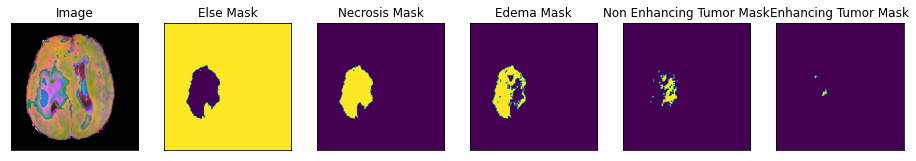

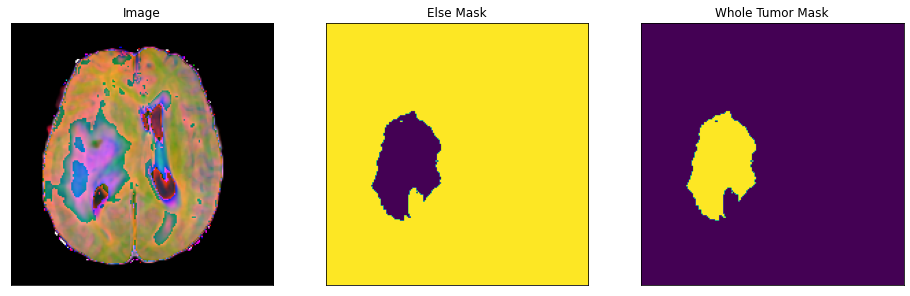

/kaggle/input/single-npy-extracted-from-brats2015/features_npy/269_56_data.npy
/kaggle/input/single-npy-extracted-from-brats2015/labels_npy/269_56_gt.npy
original image shape: (192, 192, 4)
original image deleted 1d shape: (192, 192, 3)
original mask shape: (192, 192, 1)
original mask unique values: [0 1 2 3 4]
dataset image shape: (192, 192, 3)
dataset mask shape: (192, 192, 5)
dataset mask unique values: [0. 1.]
dataset else mask unique values: [0. 1.]
dataset necrosis mask unique values: [0. 1.]
dataset edema mask unique values: [0. 1.]
dataset non enhancing tumor mask unique values: [0. 1.]
dataset enhancing tumor mask unique values: [0. 1.]
dataset whole tumor mask shape: (192, 192, 2)
dataset whole tumor mask unique values: [0. 1.]


In [14]:
show_data(test_dataset_vis,500)

In [15]:
# train_dataset
# vali_dataset
# test_dataset

train_dataloader = DataLoader(train_dataset, 16, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(vali_dataset, 8, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, 5, shuffle=False, num_workers=2)

# Model

In [16]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=5):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

torch.Size([16, 3, 192, 192]) torch.Size([16, 2, 192, 192])


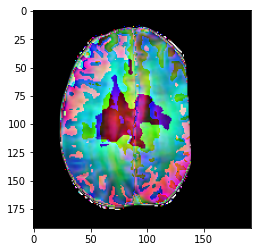

In [17]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
data = next(iter(train_dataloader))
images = data['image']
masks = data['whole_tumor_mask']
print(images.shape, masks.shape)
# for x in [images.numpy(), masks.numpy()]:
#     print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(images[3]))

# Train

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_class=2)
model = model.to(device)
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
summary(model, input_size=(3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
              ReLU-2         [-1, 64, 192, 192]               0
            Conv2d-3         [-1, 64, 192, 192]          36,928
              ReLU-4         [-1, 64, 192, 192]               0
         MaxPool2d-5           [-1, 64, 96, 96]               0
            Conv2d-6          [-1, 128, 96, 96]          73,856
              ReLU-7          [-1, 128, 96, 96]               0
            Conv2d-8          [-1, 128, 96, 96]         147,584
              ReLU-9          [-1, 128, 96, 96]               0
        MaxPool2d-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 256, 48, 48]         295,168
             ReLU-12          [-1, 256, 48, 48]               0
           Conv2d-13          [-1, 256, 48, 48]         590,080
             ReLU-14          [-1, 256,

In [19]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

In [20]:
image_datasets = {
    'train': train_dataset, 'val': vali_dataset
}

dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader
}

def train_model(model, optimizer, scheduler, num_epochs=25, best_model_path=None):
    
    if best_model_path:
        print("Loading best model weight")
        model = torch.load(best_model_path)
        best_model_wts = model.state_dict()
        model.load_state_dict(best_model_wts)
    else:
        best_model_wts = copy.deepcopy(model.state_dict())
        
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        if ((epoch % 5) == 0) and (epoch > 1):
            weight_path = '/kaggle/working/model_'+ str(epoch+1) +'.pt'
            torch.save(model,weight_path)
            print("save model")
            
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for data in dataloaders[phase]:
                inputs = data['image']
                labels = data['whole_tumor_mask']
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                
                torch.save(model,'/kaggle/working/best_model.pt')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2
num_epochs = 20
model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)
# bm_path = '/kaggle/input/unet-17epoch/best_model.pt'
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, best_model_path=None)

cuda:0
Epoch 0/19
----------
LR 0.0001


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.114194, dice: 0.368441, loss: 0.241317
val: bce: 0.112336, dice: 0.337285, loss: 0.224811
saving best model
10m 11s
Epoch 1/19
----------
LR 0.0001
train: bce: 0.079299, dice: 0.231365, loss: 0.155332
val: bce: 0.108363, dice: 0.227074, loss: 0.167718
saving best model
10m 8s
Epoch 2/19
----------
LR 0.0001
train: bce: 0.066921, dice: 0.196214, loss: 0.131567
val: bce: 0.104584, dice: 0.209657, loss: 0.157120
saving best model
10m 8s
Epoch 3/19
----------
LR 0.0001
train: bce: 0.055670, dice: 0.166625, loss: 0.111148
val: bce: 0.101012, dice: 0.208489, loss: 0.154750
saving best model
10m 7s
Epoch 4/19
----------
LR 0.0001
train: bce: 0.046965, dice: 0.147514, loss: 0.097239
val: bce: 0.089889, dice: 0.197316, loss: 0.143602
saving best model
10m 8s
Epoch 5/19
----------
save model
LR 0.0001
train: bce: 0.043060, dice: 0.136573, loss: 0.089817
val: bce: 0.120963, dice: 0.218388, loss: 0.169675
10m 7s
Epoch 6/19
----------
LR 0.0001
train: bce: 0.037825, dice: 0.126040, lo

# Test

In [22]:
def masks_to_colorimg(masks):
#     colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132)])
    colors = np.asarray([(201, 58, 64), (242, 207, 1)])
    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [23]:
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

test: bce: 0.090774, dice: 0.101587, loss: 0.096180
(5, 2, 192, 192)


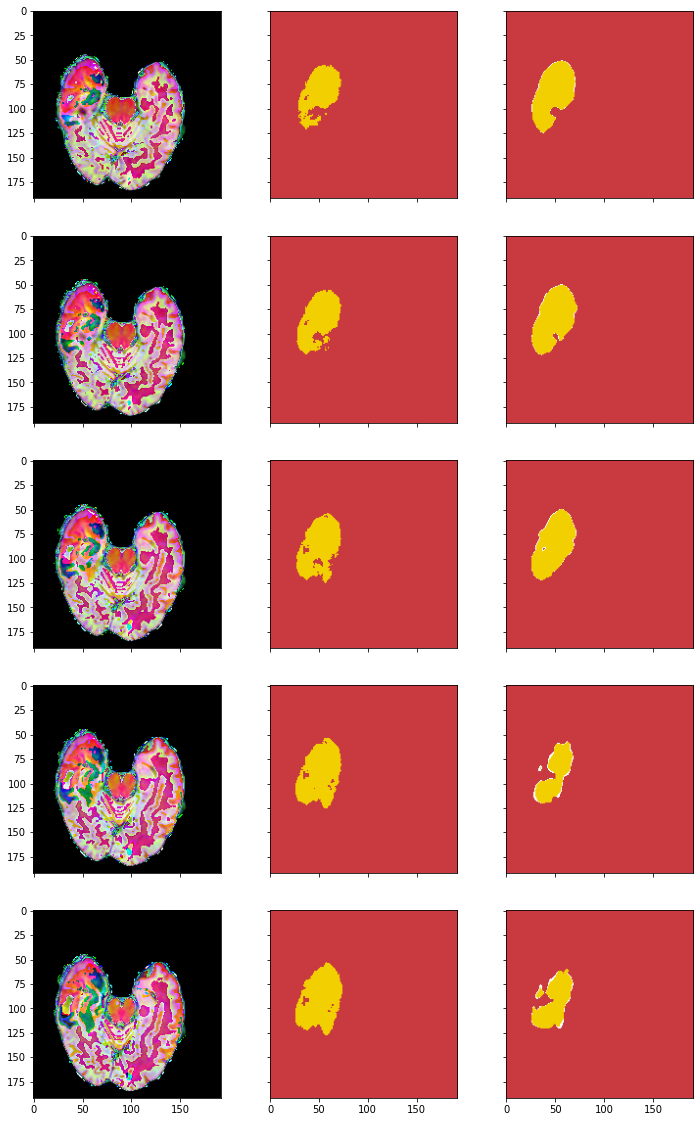

In [24]:
# prediction



best_model = torch.load('/kaggle/working/best_model.pt')
best_model_wts = best_model.state_dict()
best_model.load_state_dict(best_model_wts)
best_model.eval()   # Set model to evaluate mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = next(iter(test_dataloader))
inputs = data['image']
labels = data['whole_tumor_mask']
inputs = inputs.to(device)
labels = labels.to(device)

pred = best_model(inputs)

pred_gpu = pred.data
pred = pred_gpu.cpu().numpy()

metrics = defaultdict(float)
loss = calc_loss(pred_gpu, labels, metrics)
print_metrics(metrics, inputs.size(0), 'test')

print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])